In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import os as os
import pickle

2021-11-24 21:41:39.240631: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
file_list = os.listdir()

In [3]:
# Transform the datasets into Xs and Ys
def TransformSamples3 (sample1, sample2, sample3):
    sample1 = sample1.T.to_numpy()[1:]
    sample2 = sample2.T.to_numpy()[1:]
    sample3 = sample3.T.to_numpy()[1:]
    x = np.append(sample1, sample2, axis=0).astype('float32')
    x = np.append(x, sample3, axis=0).astype('float32')
    y = np.array([0]*len(sample1) + [1]*len(sample2)+[2]*len(sample3))
    return x, y

In [4]:
healthy_group_filename = []
moderate_group_filename = []
severe_group_filename = []
for i in file_list:
    if 'Healthy' in i:
        healthy_group_filename.append(i)
        continue
    if 'Moderate' in i:
        moderate_group_filename.append(i)
        continue
    if 'Severe' in i:
        severe_group_filename.append(i)
        continue

In [5]:
healthy_group = []
moderate_group = []
severe_group = []
for i in healthy_group_filename:
    healthy_group.append(pd.read_csv(i, index_col='Unnamed: 0'))
for i in moderate_group_filename:
    moderate_group.append(pd.read_csv(i, index_col='Unnamed: 0'))
for i in severe_group_filename:
    severe_group.append(pd.read_csv(i, index_col='Unnamed: 0'))

In [6]:
severe_group

[         Genename       Counts    Sample
 0            B9D2  1245.169400  Severe 3
 1            JAG2     6.079997  Severe 3
 2          DNASE1   427.077100  Severe 3
 3            TRMU   491.825530  Severe 3
 4            RRP9   374.227600  Severe 3
 ...           ...          ...       ...
 17201       FOXF1     0.000000  Severe 3
 17202  AC092316.1     0.000000  Severe 3
 17203   FOXP1-AS1     0.000000  Severe 3
 17204     ANKRD61     0.000000  Severe 3
 17205   TNKS2-AS1    12.892557  Severe 3
 
 [17206 rows x 3 columns],
          Genename      Counts    Sample
 0            B9D2  873.285770  Severe 1
 1            JAG2    8.139229  Severe 1
 2          DNASE1  497.972700  Severe 1
 3            TRMU  954.037960  Severe 1
 4            RRP9  905.841400  Severe 1
 ...           ...         ...       ...
 17201       FOXF1   12.618297  Severe 1
 17202  AC092316.1    0.000000  Severe 1
 17203   FOXP1-AS1    3.496724  Severe 1
 17204     ANKRD61    0.000000  Severe 1
 17205   TNKS2-A

In [15]:
genes = healthy_group[0]['Genename'].values

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()
Xs = []
ys = []
for i in healthy_group:
    Xs.append(scaler.fit_transform(np.log1p(i['Counts'].values).reshape(-1,1)).flatten())
    ys.append(0)
for i in moderate_group:
    Xs.append(scaler.fit_transform(np.log1p(i['Counts'].values).reshape(-1,1)).flatten())
    ys.append(1)
for i in severe_group:
    Xs.append(scaler.fit_transform(np.log1p(i['Counts'].values).reshape(-1,1)).flatten())
    ys.append(2)
Xs = np.array(Xs)
ys = np.array(ys)

In [13]:
Xs_train, Xs_test = train_test_split(Xs, random_state=7)
ys_train, ys_test = train_test_split(ys, random_state=7)

In [13]:
np.save('ys_severity', ys)

# Random Forest

In [103]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier

In [19]:
rf = RandomForestClassifier(max_depth=10, n_jobs=10)
rf_result_list = []
rf.fit(Xs_train,ys_train)
rf_result = pd.DataFrame({'Gene index':np.arange(len(genes)),
              'Importance':rf.feature_importances_}).sort_values(by='Importance')
#rf_result_selected = rf_result[rf_result['Importance']!=0]
#rf_result_list.append(rf_result_selected)
rf.score(Xs_test, ys_test)

0.8333333333333334

In [41]:
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

0.8333333333333334
0.8333333333333334


Text(137.16666666666669, 0.5, 'Truth')

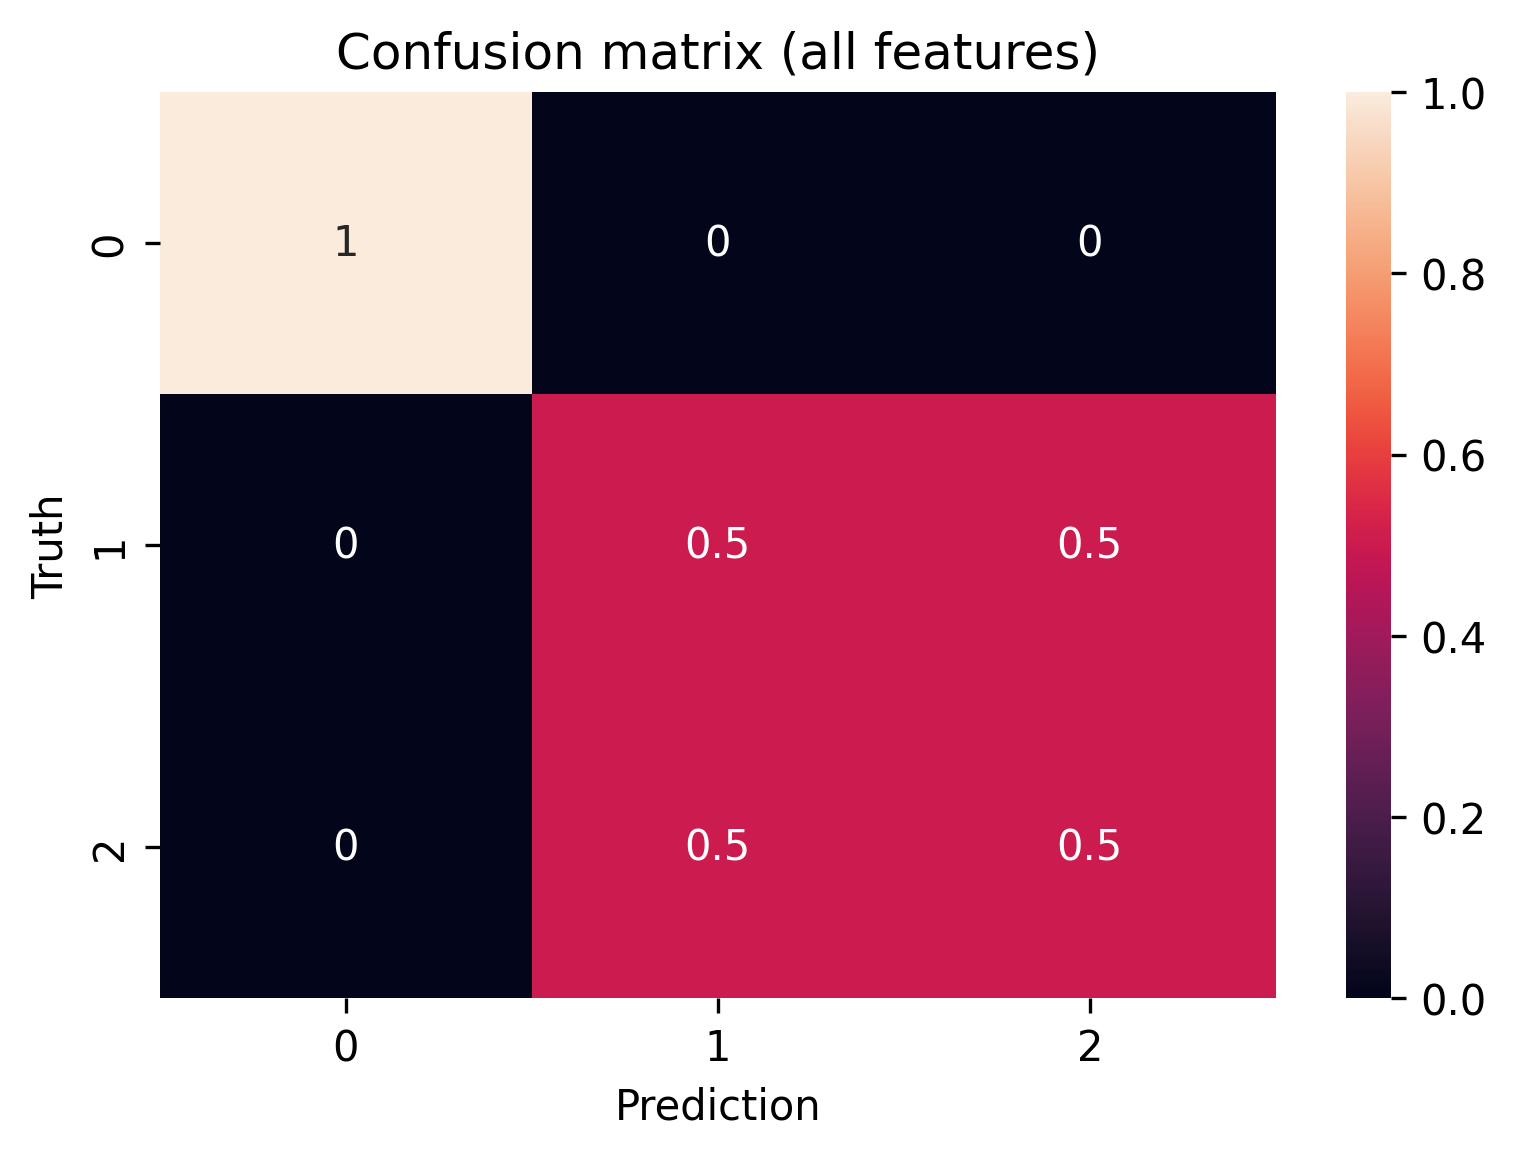

In [68]:
import seaborn as sns
print(recall_score(ys_test, rf.predict(Xs_test), average='micro'))
print(precision_score(ys_test, rf.predict(Xs_test), average='micro'))
c1 = confusion_matrix(ys_test, rf.predict(Xs_test))
c1_prob = []
for i in c1:
    c1_prob.append(i/i.sum())
plt.figure(dpi=300)
ax = sns.heatmap(c1_prob,annot=True)
ax.set_title('Confusion matrix (all features)')
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')

In [24]:
rf_result_selected = pd.read_csv('RF_selected_genes.csv', index_col = 'Unnamed: 0')

In [31]:
# An accuracy improvement!
rf_new = RandomForestClassifier(max_depth=10, n_jobs=10)
rf_new.fit(Xs_train[:,rf_result_selected['Gene index']], ys_train)
rf_new.score(Xs_test[:,rf_result_selected['Gene index']], ys_test)

0.9166666666666666

0.9166666666666666
0.9166666666666666


Text(137.16666666666669, 0.5, 'Truth')

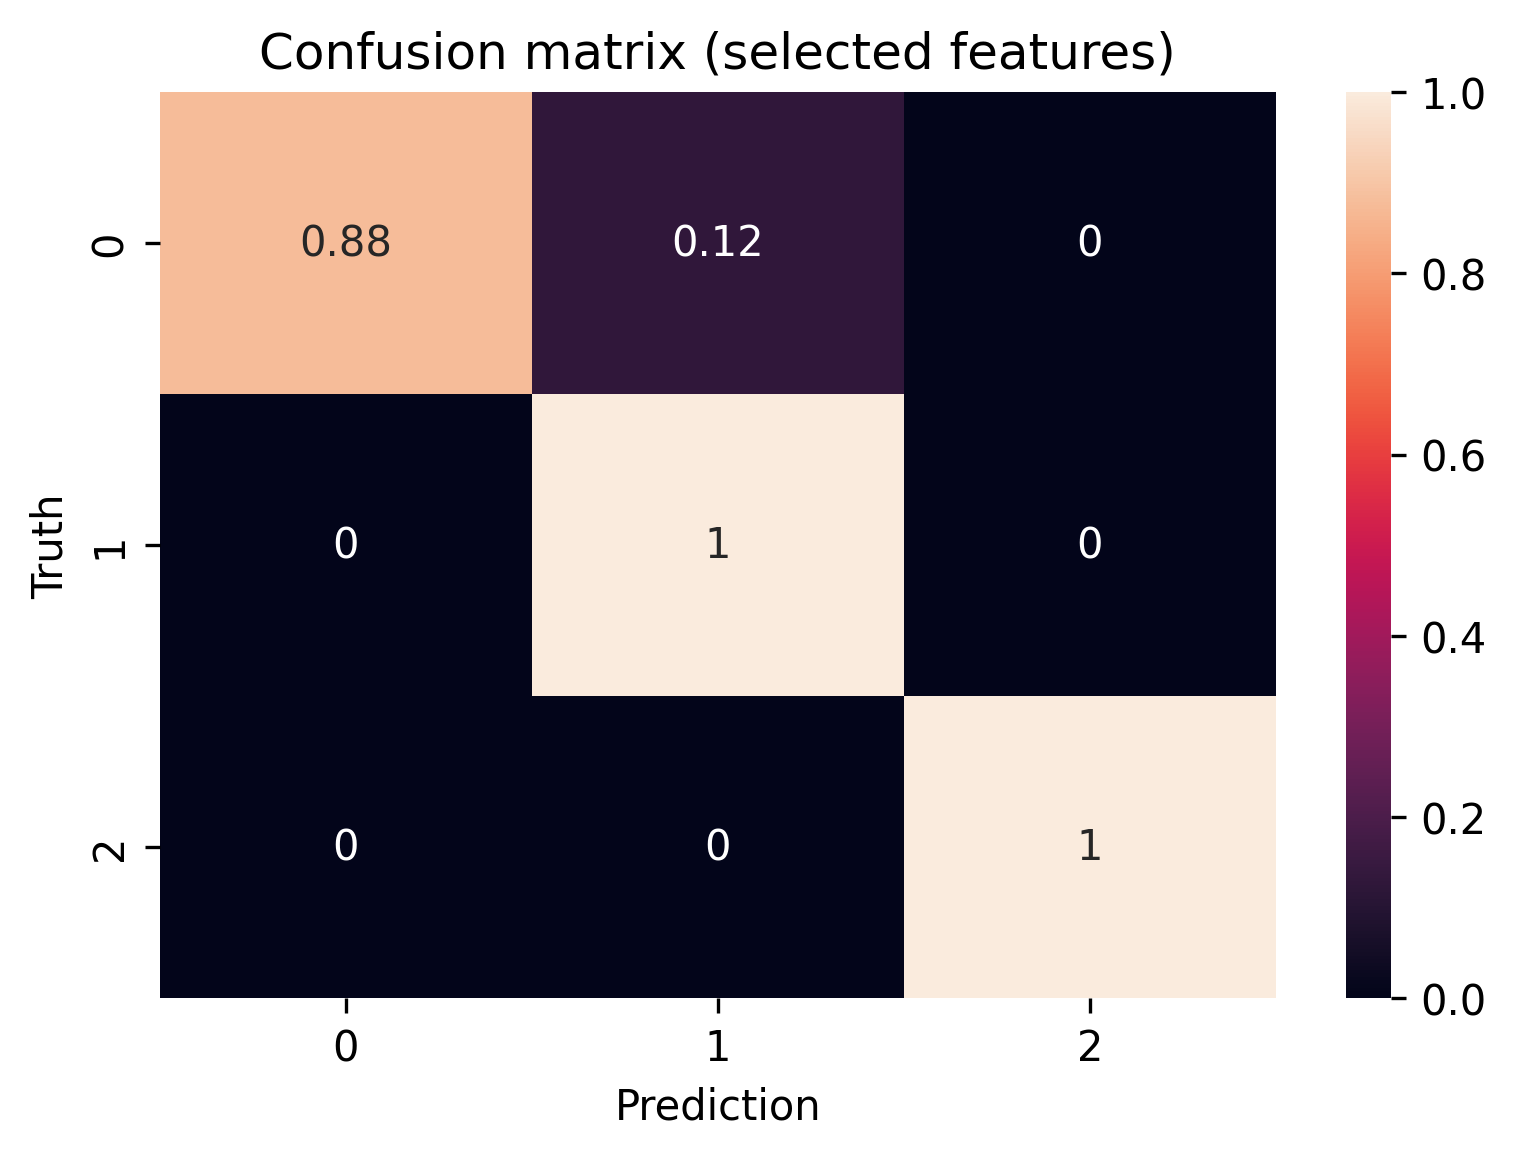

In [67]:
print(recall_score(ys_test, rf_new.predict(Xs_test[:,rf_result_selected['Gene index']]), average='micro'))
print(precision_score(ys_test, rf_new.predict(Xs_test[:,rf_result_selected['Gene index']]), average='micro'))
c2 = confusion_matrix(ys_test, rf_new.predict(Xs_test[:,rf_result_selected['Gene index']]))
c2_prob = []
for i in c2:
    c2_prob.append(i/i.sum())
plt.figure(dpi=300)
ax = sns.heatmap(c2_prob,annot=True,)
ax.set_title('Confusion matrix (selected features)')
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')

In [20]:
# Save the RF model
with open ('RF.pickle', 'wb') as file:
    pickle.dump(rf, file)

In [21]:
with open ('RF.pickle', 'rb') as file:
    rf_load = pickle.load(file)

In [22]:
rf_load.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.00290834,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00073881, 0.        , 0.00305556, 0.        , 0.        ,
       0.        , 0.00361842, 0.00099564, 0.        , 0.        ,
       0.00084615, 0.00406433, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00459069,
       0.        , 0.        , 0.        , 0.00457569, 0.        ,
       0.        , 0.        , 0.00088   , 0.00091667, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00409582, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00086075, 0.00090815, 0.        , 0.        ,
       0.        , 0.0012375 , 0.        , 0.01162561, 0.00310

In [23]:
rf_load.score(Xs[:,rf_result_selected['Gene index']], ys)

0.9777777777777777

In [24]:
rf.predict_proba(Xs_test[:,rf_result_selected['Gene index']])

array([[0.89, 0.06, 0.05],
       [0.63, 0.12, 0.25],
       [0.87, 0.08, 0.05],
       [0.94, 0.04, 0.02],
       [0.8 , 0.16, 0.04],
       [0.73, 0.26, 0.01],
       [0.65, 0.07, 0.28],
       [0.54, 0.36, 0.1 ],
       [0.02, 0.51, 0.47],
       [0.1 , 0.03, 0.87],
       [0.85, 0.06, 0.09],
       [0.12, 0.24, 0.64]])

In [25]:
pd.DataFrame({'Gene index':rf_result_selected['Gene index'].values,
              'Gene name':genes[rf_result_selected['Gene index'].values]}).to_csv('RF_selected_genes.csv')

In [26]:
selected_genes = []
for i in rf_result_selected['Gene index']:
    selected_genes.append(genes[i])
rf_result_selected['Gene name'] = selected_genes
rf_result_selected.to_csv('RF_selected_genes.csv')
selected_genes = pd.read

/tmp/ipykernel_247836/2856623931.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_result_selected['Gene name'] = selected_genes


In [27]:
rf_result_selected.sort_values(by='Importance',ascending=False).to_csv('RF_selected_genes.csv')

# Recursive feature elimination

In [28]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

In [29]:
estimator = SVC(C=3, kernel='linear')
selector = RFE(estimator)

In [30]:
selector = selector.fit(Xs, ys)

In [31]:
selected_genes = np.unique(np.append(np.unique(selector.ranking_[:1000,]),rf_result_selected['Gene index'].values))

In [32]:
selected_genes = pd.DataFrame({'Gene index':selected_genes,
                               'Gene name': genes[selected_genes]})

In [33]:
selected_genes

,Gene index,Gene name
0,1,JAG2
1,2,DNASE1
2,22,XPC
3,31,AKT2
4,35,IGHG1
...,...,...
968,16588,AKAP2
969,16808,ACHE
970,16837,NCR1
971,17046,FAM225A


In [34]:
selected_genes.to_csv('RFE_selected_genes.csv')

In [5]:
np.savetxt('Severity_related',pd.read_csv('selected_genes.csv', index_col='Unnamed: 0')['Gene name'])

0          JAG2
1         RPS16
2          CFL1
3        OGFRL1
4       TMEM245
         ...   
963    ARHGEF37
964     SLC15A5
965       ASB14
966    ARHGAP36
967      ZNF564
Name: Gene name, Length: 968, dtype: object

In [36]:
pd.read_csv('RFE_selected_genes.csv')

,Unnamed: 0,Gene index,Gene name
0,0,1,JAG2
1,1,2,DNASE1
2,2,22,XPC
3,3,31,AKT2
4,4,35,IGHG1
...,...,...,...
968,968,16588,AKAP2
969,969,16808,ACHE
970,970,16837,NCR1
971,971,17046,FAM225A


# Lasso Selection

In [73]:
from sklearn.linear_model import LogisticRegression
lasso_log = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr')
lasso_log.fit(Xs_train, ys_train)

LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear')

In [79]:
lasso_index = []
for i in range(len(lasso_log.coef_)):
    for j in range(len(lasso_log.coef_[i])):
        if lasso_log.coef_[i][j]!=0:
            lasso_index.append(j)
lasso_result_selected = pd.DataFrame({'Gene index':lasso_index,
                                      'Gene name':genes[lasso_index]})
lasso_result_selected

,Gene index,Gene name
0,388,IFI27
1,13181,ADAMTS2
2,16715,VMO1
3,129,MTRNR2L8
4,388,IFI27
5,3232,DDX3Y
6,11757,ZFY
7,11766,MT2A
8,354,MT-ATP8
9,1861,XIST


In [80]:
lasso_result_selected.to_csv('Lasso_selected')

In [91]:
lasso_log_fs = LogisticRegression(solver='liblinear')
lasso_log_fs.fit(Xs_train[:,lasso_index], ys_train)
lasso_log_fs.score(Xs_test[:,lasso_index], ys_test)

0.9166666666666666